In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def fillDMap(DMap):
    globalMin = np.min(DMap[DMap>0])
    NDMap = DMap
    n, m = DMap.shape
    for i in range(n):
        l = 0
        rec = False
        recMin = globalMin
        for j in range(m):
            if (DMap[i,j] == 0 and not rec):
                l = j
                rec = True
                recMin = 0
                if (j > 0):
                    recMin = DMap[i,j-1]
            elif ((DMap[i,j] > 0 or j == m-1) and rec):
                rec = False
                if (j < m-1):
                    recMin = DMap[i,j]
                if (recMin == 0):
                    recMin = globalMin
                NDMap[i,l:j] = recMin
    return NDMap

In [3]:
def normalizeMap(M):
    return (M - np.min(M))/(np.max(M) - np.min(M))

In [4]:
def normalizeEMap(E):
    return ((E - np.min(E))*255 + 1)/(np.max(E) - np.min(E))/256

In [5]:
def cellBounds(E):
    n, m = E.shape
    row_num = int(np.sqrt(n))
    col_num = int(np.sqrt(m))
    col_weights = np.sum(E, axis=0)
    row_weights = np.sum(E, axis=1)
    tot_weight = np.sum(E)
    R = (n * np.linspace(0, row_num, row_num + 1) / row_num).astype(np.uint16)
    C = (m * np.linspace(0, col_num, col_num + 1) / col_num).astype(np.uint16)
    R_weight = np.zeros((row_num))
    C_weight = np.zeros((col_num))

    for i in range(row_num):
        R_weight[i] = np.sum(E[R[i]:R[i+1],:])
    for i in range(col_num):
        C_weight[i] = np.sum(E[:,C[i]:C[i+1]])
    
    return (R, R_weight, C, C_weight)

In [6]:
def warp(I, E_raw, target_size):
    E = normalizeEMap(E_raw)
    R, R_k, C, C_k = cellBounds(E)
    row_num, col_num = R.size - 1, C.size - 1
    n, m = target_size
    n_in, m_in = E.shape
    R_l, C_l = R[1:] - R[:-1], C[1:] - C[:-1]
    R_l = np.resize(R_l, (row_num, 1))
    C_l = np.resize(C_l, (col_num, 1))
    min_R = np.min(R_l)
    min_C = np.min(C_l)
    avg_R_k = np.mean(R_k)
    avg_C_k = np.mean(C_k)
    
    d_R, d_C = None, None
    
    while (True):
        A_R = np.zeros((row_num, row_num))
        for i in range(row_num - 1):
            A_R[i,:] = np.concatenate([np.zeros(i), [1, -1], np.zeros(row_num-i-2)])
        A_R[-1,:] = 1/R_k
        b_R = np.zeros((row_num, 1))
        b_R[-1,0] = n - n_in
        x_R = np.resize(np.linalg.solve(A_R, b_R), (row_num))
        d_R = x_R/R_k
        if (np.floor(min_R + np.min(d_R)) <= 1):
            R_k = R_k + avg_R_k*0.1
        else:
            break
    
    while (True):
        A_C = np.zeros((col_num, col_num))
        for i in range(col_num - 1):
            A_C[i,:] = np.concatenate([np.zeros(i), [1, -1], np.zeros(col_num-i-2)])
        A_C[-1,:] = 1/C_k
        b_C = np.zeros((col_num, 1))
        b_C[-1,0] = m - m_in
        x_C = np.resize(np.linalg.solve(A_C, b_C), (col_num))
        d_C = x_C/C_k
        if (np.floor(min_C + np.min(d_C)) <= 1):
            C_k = C_k + avg_C_k*0.1
        else:
            break

    R_out, C_out = np.zeros((row_num + 1), dtype=np.uint16), np.zeros((col_num + 1), dtype=np.uint16)
    for i in range(row_num):
        R_out[i+1] = R_out[i] + np.uint16(R_l[i] + d_R[i])
    R_out[row_num] = n
    for i in range(col_num):
        C_out[i+1] = C_out[i] + np.uint16(C_l[i] + d_C[i])
    C_out[col_num] = m

    I_out = np.zeros((n, m, 3))

    for i in range(row_num):
        for j in range(col_num):
            resized_patch = cv.resize(I[R[i]:R[i+1], C[j]:C[j+1], :], (C_out[j+1]-C_out[j], R_out[i+1]-R_out[i]))
            I_out[R_out[i]:R_out[i+1],C_out[j]:C_out[j+1],:] = resized_patch
    return I_out.astype(np.uint8)

In [7]:
def resize(I, E, target_size, mode):
    I_interm = None
    E_interm = None
    n_in, m_in = E.shape
    n, m = target_size
    if (mode == 0):
        I_interm = I
        E_interm = E
    elif ((mode > 0) != (n/n_in > m/m_in)):
        I_interm = cv.resize(I, (m, np.int16(n*m/m_in)))
        E_interm = cv.resize(E, (m, np.int16(n*m/m_in)))
    else:
        I_interm = cv.resize(I, (np.int16(m*n/n_in), n))
        E_interm = cv.resize(E, (np.int16(m*n/n_in), n))
    return warp(I_interm, E_interm, target_size)

In [8]:
def CAIR(img_name, target_size, mode):
    I = cv.imread("Samples/" + img_name + ".png")
    DM = normalizeMap(fillDMap(cv.cvtColor(cv.imread("Samples/" + img_name + "_DMap.png"), cv.COLOR_RGB2GRAY)))
    SM = normalizeMap(cv.cvtColor(cv.imread("Samples/" + img_name + "_SMap.png"), cv.COLOR_RGB2GRAY))
    n, m = SM.shape
    E = np.exp(np.log(5)*(DM-1)) + SM
    return resize(I, E, target_size, mode)

In [9]:
def ratioCAIR(img_name, target_ratio, mode):
    I = cv.imread("Samples/" + img_name + ".png")
    DM = normalizeMap(fillDMap(cv.cvtColor(cv.imread("Samples/" + img_name + "_DMap.png"), cv.COLOR_RGB2GRAY)))
    SM = normalizeMap(cv.cvtColor(cv.imread("Samples/" + img_name + "_SMap.png"), cv.COLOR_RGB2GRAY))
    n, m = SM.shape
    u, v = target_ratio
    E = np.exp(np.log(5)*(DM-1)) + SM
    return resize(I, E, (int(n*u), int(m*v)), mode)

In [10]:
def halfCAIR(img_name, mode):
    J = ratioCAIR(img_name, (1., .5), mode)
    cv.imwrite("Results/"+img_name + "Out.png", J)

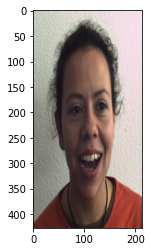

In [13]:
J = cv.cvtColor(ratioCAIR("Diana", (1, .5), 1), cv.COLOR_BGR2RGB)
plt.imshow(J)

In [ ]:
outCAIR("Snowman", (364, 227), -1)